In [1]:
import numpy as np
import pandas as pd
from glob import glob
from subprocess import check_output

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score

import pylab as plt
%matplotlib inline

## Get data

In [2]:
with open('../forecast_pipeline/pipeline_data/steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
    
ns = len(steps)

steps_c = [f'case{i}' for i in range(ns)]
steps_d = [f'death{i}' for i in range(ns)]
steps_ = steps_c + steps_d

In [3]:
data_fname = glob('../forecast_pipeline/pipeline_data/data_????-??-??.csv')[0]
df = pd.read_csv(data_fname, dtype={'fips': str}).set_index('fips')
# tmp = df[[col for col in df.columns if col.startswith('case') or col.startswith('death')]]
# (tmp < 0).sum()

In [5]:
df['age_risk'] = df['perc_65yrs'] * (df['risk_flu'] - df['risk_flu'].min())
covariates = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
    'risk_flu',
    'age_risk'
]
cov = '+'.join(covariates)

df_z = df[steps_].copy()
for c in covariates:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

,case0,case1,case2,case3,case4,case5,case6,case7,case8,case9,...,population,perc_65yrs,perc_minority,perc_black,perc_hispanic,perc_poverty,perc_urban_pop,income,risk_flu,age_risk
fips,,,,,,,,,,,,,,,,,,,,,
01001,12.0,7.0,6.0,11.0,9.0,23.0,42.0,45.0,61.0,43.0,...,-0.149053,-0.794106,0.512705,0.741329,-0.489703,-0.225017,0.535824,0.480936,1.006875,0.619816
01003,29.0,37.0,43.0,38.0,34.0,35.0,38.0,19.0,10.0,21.0,...,0.349320,0.257409,-0.180113,-0.042334,-0.365711,-0.883379,0.526204,0.353735,1.296454,1.809519
01005,2.0,7.0,9.0,14.0,11.0,15.0,21.0,26.0,45.0,40.0,...,-0.241908,-0.012923,2.192825,2.685016,-0.379632,2.589482,-0.291414,-1.333023,0.420657,0.588933
01007,4.0,9.0,13.0,8.0,8.0,3.0,5.0,8.0,14.0,5.0,...,-0.248733,-0.647773,0.481481,0.821243,-0.504693,1.091708,-0.310652,-0.483902,0.436170,0.195242
01009,10.0,2.0,8.0,11.0,9.0,4.0,1.0,4.0,12.0,9.0,...,-0.143225,-0.221003,-0.699751,-0.532156,-0.011632,-0.323771,-1.003223,-0.167862,0.617627,0.664915


## Get GLM predictions

### Case 

In [6]:
cors = []
for i in range(len(steps_c)):
    cur = steps_c[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.2021e+05
Date:                Fri, 13 Nov 2020   Deviance:                   4.3055e+05
Time:                        14:57:35   Pearson chi2:                 9.67e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.8386      0.011     79.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case4   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3608e+05
Date:                Fri, 13 Nov 2020   Deviance:                   2.6285e+05
Time:                        14:57:35   Pearson chi2:                 1.17e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.0824      0.008    253.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case8   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -70975.
Date:                Fri, 13 Nov 2020   Deviance:                   1.3223e+05
Time:                        14:57:35   Pearson chi2:                 2.48e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.3111      0.007    310.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case12   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0677e+05
Date:                Fri, 13 Nov 2020   Deviance:                   2.0182e+05
Time:                        14:57:35   Pearson chi2:                 3.45e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.6411      0.006    440.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case16   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4217e+05
Date:                Fri, 13 Nov 2020   Deviance:                   2.6954e+05
Time:                        14:57:36   Pearson chi2:                 3.92e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.4083      0.004    855.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case20   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -84461.
Date:                Fri, 13 Nov 2020   Deviance:                   1.5453e+05
Time:                        14:57:36   Pearson chi2:                 2.04e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.3524      0.004    818.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case24   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -96142.
Date:                Fri, 13 Nov 2020   Deviance:                   1.7723e+05
Time:                        14:57:36   Pearson chi2:                 2.58e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.6229      0.004    985.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case28   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0361e+05
Date:                Fri, 13 Nov 2020   Deviance:                   1.9061e+05
Time:                        14:57:36   Pearson chi2:                 2.40e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.9191      0.003   1253.

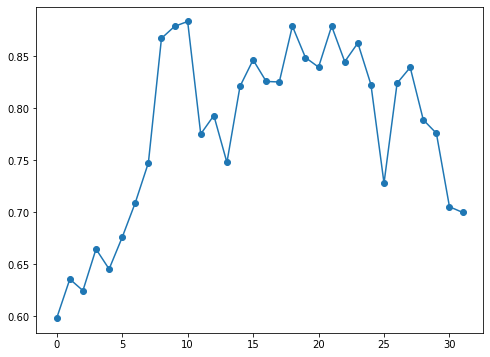

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

### Death

In [8]:
cors = []
for i in range(len(steps_d)):
    cur = steps_d[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10722.
Date:                Fri, 13 Nov 2020   Deviance:                       19388.
Time:                        14:58:11   Pearson chi2:                 2.29e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.9083      0.074    -52.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death4   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11889.
Date:                Fri, 13 Nov 2020   Deviance:                       21049.
Time:                        14:58:11   Pearson chi2:                 4.22e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.5785      0.042    -37.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death8   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6151.3
Date:                Fri, 13 Nov 2020   Deviance:                       9890.0
Time:                        14:58:12   Pearson chi2:                 2.18e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.2218      0.041    -29.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death12   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6868.6
Date:                Fri, 13 Nov 2020   Deviance:                       11545.
Time:                        14:58:12   Pearson chi2:                 2.81e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.4399      0.044    -32.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death16   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5136.0
Date:                Fri, 13 Nov 2020   Deviance:                       7376.2
Time:                        14:58:12   Pearson chi2:                 1.56e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.9265      0.033    -27.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death20   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5311.7
Date:                Fri, 13 Nov 2020   Deviance:                       7162.4
Time:                        14:58:12   Pearson chi2:                 1.09e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.6138      0.029    -21.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death24   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5158.4
Date:                Fri, 13 Nov 2020   Deviance:                       6786.4
Time:                        14:58:13   Pearson chi2:                 1.06e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.4338      0.026    -16.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death28   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5235.5
Date:                Fri, 13 Nov 2020   Deviance:                       6896.9
Time:                        14:58:13   Pearson chi2:                 1.13e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3006      0.024    -12.

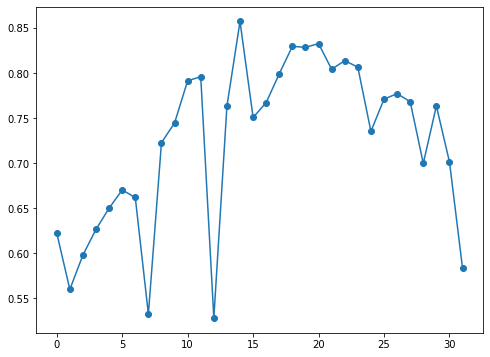

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

In [18]:
# cleanup and save
existing_csv = glob('data/data_????-??-??_glm.csv')

if len(existing_csv) > 0:
    for csv in existing_csv:
        check_output(f'rm {csv}', shell=True)

prefix =data_fname.split('/')[-1][:-4]
save_fname =f"data/{prefix}_glm.csv"
df_z.to_csv(save_fname, float_format='%.2f')

In [15]:
f"data/{data_fname.split('/')[-1][:-4]}_glm.csv"

'data/data_2020-11-12_glm.csv'

## Validation

In [12]:
cols = [col for col in df_z.columns if (col.startswith('case')) or (col.startswith('death'))]
(df_z[cols] < 0).sum().sum()

0